In [1]:
import jieba as jb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, plot, iplot
from scipy.cluster.hierarchy import ward
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from wordcloud import WordCloud

In [2]:
init_notebook_mode(connected=True)

In [3]:
stop＿words = [',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', 
             '（', '）', ',', ':']

In [4]:
groups = {
    'stop_titles':['主席','全委會主席','代理主席','代理全委會主席','秘書'],
    '政府':[
        '行政長官','財政司司長','政務司司長','律政司司長','教育局局長','教育局副局長',
        '運輸及房屋局局長','運輸及房屋局副局長','保安局局長','保安局副局長','民政事務局局長',
        '財經事務及庫務局局長','財經事務及庫務局副局長','發展局局長','財經事務及庫務局局長',
        '政制及內地事務局局長','政制及內地事務局副局長','勞工及福利局局長','勞工及福利局副局長',
        '商務及經濟發展局局長','商務及經濟發展局副局長','公務員事務局局長','創新及科技局局長',
        '食物及衞生局局長','食物及衞生局副局長','環境局局長'
    ],
    '民主黨':['許智峯議員','林卓廷議員','尹兆堅議員','林卓廷議員','涂謹申議員','胡志偉議員',
            '鄺俊宇議員','黃碧雲議員'],
    '公民黨':['陳淑莊議員','郭榮鏗議員','譚文豪議員','郭家麒議員','楊岳橋議員'],
    '公專聯':['梁繼昌議員','莫乃光議員'],
    '社民連':['梁國雄議員'],
    '人力':['陳志全議員'],
    '土盟':['朱凱廸議員'],
    '工黨':['張超雄議員'],
    '街工':['梁耀忠議員'],
    '眾志':['羅冠聰議員'],
    '教協':['葉建源議員'],
    '民主教室':['劉小麗議員'],
    '熱血公民':['鄭松泰議員'],
    '專業議政':['姚松炎議員'],
    '香港本土':['毛孟靜議員'],
    '青年新政':['梁頌恆議員','游蕙禎議員'],
    '泛民獨立':['李國麟議員','邵家臻議員'],

    '民建聯':['梁美芬議員','李慧琼議員','何俊賢議員','劉國勳議員','周浩鼎議員','張國鈞議員',
           '柯創盛議員','梁志祥議員','葛珮帆議員','蔣麗芸議員','陳克勤議員','陳恒鑌議員',
           '黃定光議員'],
    '經民聯':['石禮謙議員','劉業強議員','張華峰議員','林健鋒議員','梁君彥議員','梁美芬議員',
            '盧偉國議員','石禮謙議員'],
    '工聯會':['黃國健議員','麥美娟議員','陸頌雄議員','郭偉強議員','何啟明議員'],
    '自由黨':['鍾國斌議員','邵家輝議員','張宇人議員','易志明議員'],
    '新民黨':['葉劉淑儀議員','容海恩議員'],
    '新論壇':['馬逢國議員','何君堯議員'],
    '勞聯':['潘兆平議員'],
    '獨立建制':['謝偉俊議員','吳永嘉議員','姚思榮議員','廖長江議員','田北辰議員','陳健波議員',
            '陳振英議員'],
    
    '中間獨立':['陳沛然議員']
}

In [5]:
Ideology = {
    'stop_ideology': ['stop_titles', '政府', '中間獨立'],
    'pro-china': ['民建聯', '經民聯', '工聯會', '自由黨', '新民黨', '新論壇', '勞聯',
                  '獨立建制'],
    'pro-democracy': ['民主黨', '公民黨', '公專聯', '社民連', '人力', '土盟', '工黨',
                      '街工', '眾志', '教協', '民主教室', '熱血公民', '專業議政',
                      '香港本土', '青年新政', '泛民獨立'],
}

In [6]:
raw_data = pd.read_csv('立法會會議過程正式紀錄 - 2016-2017 年度 .csv')
raw_data.Date = pd.to_datetime(raw_data.Date, format='%Y-%m-%d')
raw_data.Title = raw_data.Title.map(str.strip)
raw_data = raw_data[raw_data.Title != '(梁國雄議員站起來']
raw_data = raw_data[raw_data.Title.map(len) <= 12]

In [7]:
def groups_return(x):
    for i in range(len(list(groups.values()))):
        if x in (list(groups.values())[i]):
            key_idx = i 
    return list(groups.keys())[key_idx]

In [8]:
# groups_return('陳沛然議員')

In [9]:
def ideology_return(x):
    for i in range(len(list(Ideology.values()))):
        if x in (list(Ideology.values())[i]):
            key_idx = i
    return list(Ideology.keys())[key_idx]

In [10]:
# ideology_return('公民黨')

In [11]:
raw_data['Groups'] = raw_data['Title'].map(groups_return)
raw_data['Ideology'] = raw_data['Groups'].map(ideology_return)

In [12]:
# raw_data.head()

In [13]:
# set(raw_data.Title)

In [14]:
plot_data = pd.DataFrame(raw_data.groupby('Title').count(
).Date.rename('Num').sort_values(axis=0, ascending=False))[:20]

In [15]:
bar_data = [Bar(x=plot_data.index, y=plot_data.Num)]

In [16]:
iplot(bar_data)

In [17]:
plot_data = pd.DataFrame(
    raw_data[~raw_data['Groups'].isin(['stop_titles', '政府'])].groupby('Groups').count(
    ).Date.rename('Num').sort_values(axis=0, ascending=False))
bar_data = [Bar(x=plot_data.index, y=plot_data.Num)]

In [18]:
iplot(bar_data)

In [19]:
plot_data = pd.DataFrame(
    raw_data[~raw_data['Groups'].isin(['stop_titles', '政府'])].groupby('Groups').count(
    ).Date.rename('Num').sort_values(axis=0, ascending=False))

bar_data = [
    Bar(
        x=(plot_data.Num/np.array([len(groups[i]) for i in plot_data.index])).sort_values(ascending=False).index, 
        y=(plot_data.Num/np.array([len(groups[i]) for i in plot_data.index])).sort_values(ascending=False)
    )
]

In [20]:
iplot(bar_data)

In [21]:
iplot(bar_data)

In [22]:
def df_groups_selection(raw_data, groups, num=20):
    dataframe = pd.DataFrame(raw_data[raw_data.Groups == groups].groupby('Title').count().Date.rename('Num').sort_values(axis=0, ascending=False))[:20]
    return (list(dataframe.index), list(dataframe.Num))

In [23]:
bar_data = [Bar(x=df_groups_selection(raw_data, '民建聯')[0],
                y=df_groups_selection(raw_data, '民建聯')[1])]
iplot(bar_data)

In [24]:
bar_data = [Bar(x=df_groups_selection(raw_data, '民主黨')[0],
                y=df_groups_selection(raw_data, '民主黨')[1])]
iplot(bar_data)

In [25]:
words_data = raw_data['Text'].map(lambda x: ' '.join(jb.cut(x))).values

Building prefix dict from /usr/local/lib/python3.5/dist-packages/jieba/dict.txt ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.674 seconds.
Prefix dict has been built succesfully.


In [26]:
cv = CountVectorizer(min_df=3, max_df=.90, decode_error='ignore',
                     stop_words=stop_words, max_features=1000).fit(words_data)

In [27]:
feature = cv.get_feature_names()
counts = cv.transform(words_data).toarray().sum(axis=0)

In [28]:
ship_masked = np.array(Image.open('masked_ship.png'))

In [29]:
def word_clouds(raw_data_text, mask, cv, num_skipped=100, background_color='white'):

    words_data = raw_data_text.map(lambda x: ' '.join(jb.cut(x))).values
    feature = cv.get_feature_names()
    counts = cv.transform(words_data).toarray().sum(axis=0)
    count_sort = counts.argsort()
    
    terms = ""
    for i in count_sort[-num_skipped::-1]:
        terms += (feature[i] + ' ') * counts[i]

    font_path = './hanazono-20160201 (1)/HanaMinA.ttf'
    wordcloud = WordCloud(font_path=font_path, max_words=2000,
                          mask=mask, background_color=background_color,
                          collocations=False).generate(terms)
    plt.figure(figsize=(12, 9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

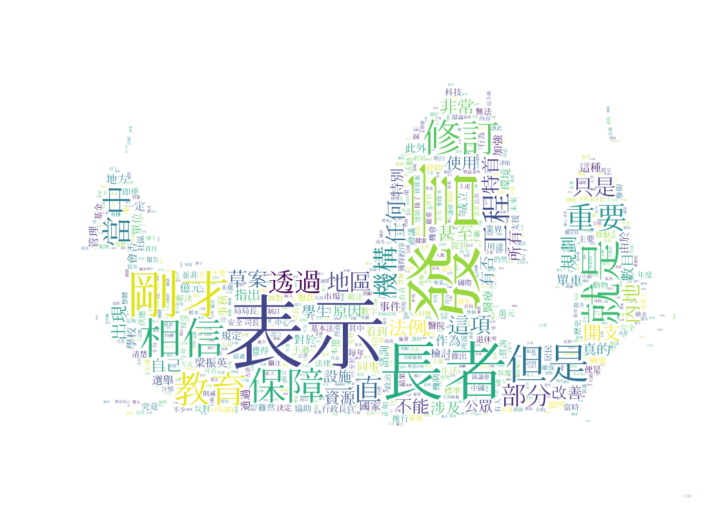

In [30]:
word_clouds(raw_data[raw_data.Groups != 'stop_titles'].Text, ship_masked, cv)

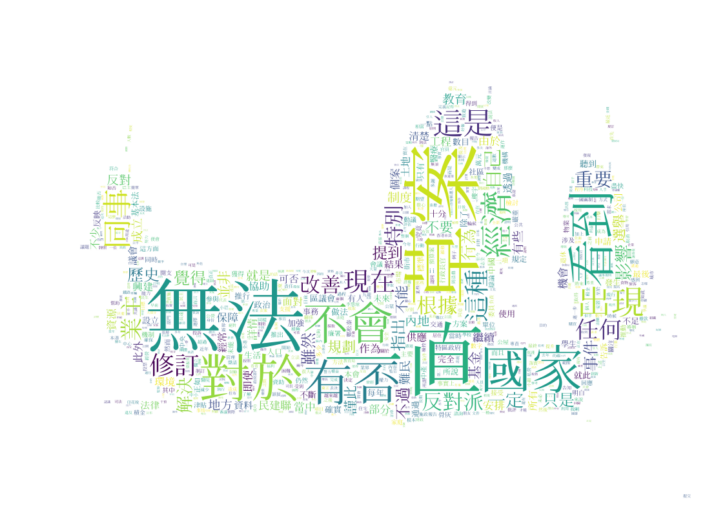

In [31]:
word_clouds(raw_data[raw_data.Groups == '民建聯'].Text, ship_masked, cv)

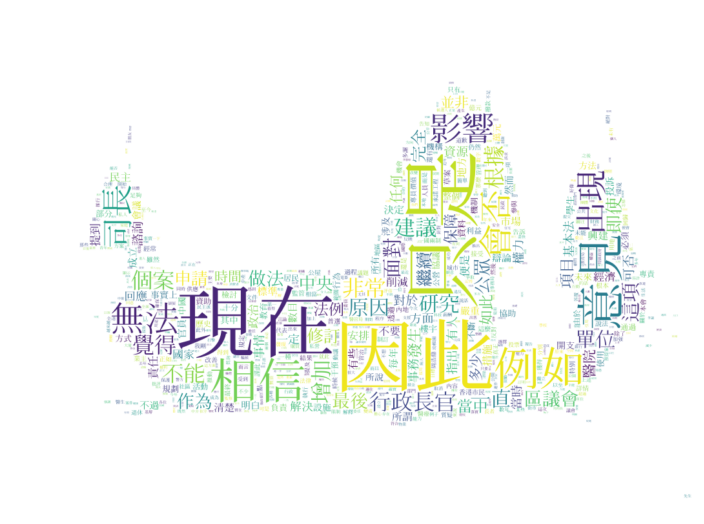

In [32]:
word_clouds(raw_data[raw_data.Groups == '民主黨'].Text, ship_masked, cv)

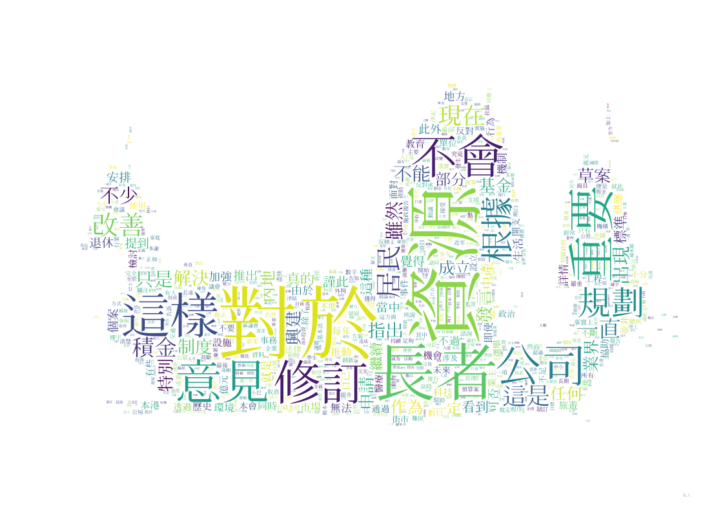

In [33]:
word_clouds(raw_data[raw_data.Ideology == 'pro-china'].Text, ship_masked, cv)

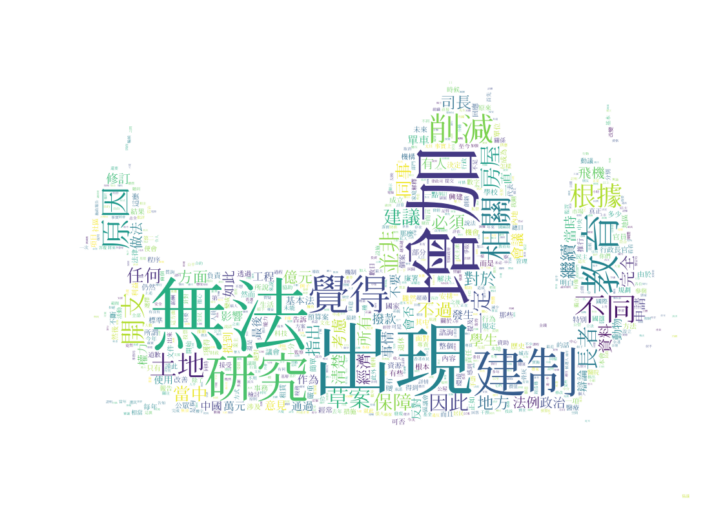

In [34]:
word_clouds(raw_data[raw_data.Ideology == 'pro-democracy'].Text, ship_masked, cv)

In [35]:
# by groups word cloud, form month col, form 建制/泛民 col, form 功能組別/一般 col, similarity

In [36]:
# http://brandonrose.org/clustering
# https://stackoverflow.com/questions/27889873/clustering-text-documents-using-scikit-learn-kmeans-in-python
# https://nlpforhackers.io/recipe-text-clustering/
# http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

In [37]:
titleSet = raw_data.Title.unique()
dfDict = {elem: pd.DataFrame for elem in titleSet}
for key in dfDict.keys():
    dfDict[key] = raw_data[raw_data.Title == key].Text.values

cvDict = {elem: 0 for elem in titleSet}
for key in cvDict.keys():
    cvDict[key] = cv.transform(dfDict[key]).toarray().sum(axis=0)

cvArray = np.array([cvDict[list(cvDict.keys())[0]]])
for key in list(cvDict.keys())[1:]:
    cvArray = np.concatenate((cvArray, [cvDict[key]]), axis=0)

In [38]:
dist = euclidean_distances(cvArray)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pos = mds.fit_transform(dist)

In [39]:
xs, ys = pos[:, 0], pos[:, 1]

In [40]:
names = list(cvDict.keys())

In [41]:
stop_list = groups['stop_titles'] + groups['政府']

In [42]:
# data = [Scatter(
#     x = xs,
#     y = ys,
#     mode = 'markers',
#     text = names
#                )]
# fig = Figure(data=data)
# iplot(fig)

In [43]:
new_xs, new_ys, new_names = [], [], []
for x, y, name in zip(xs, ys, names):
    if name not in stop_list:
        new_xs.append(x)
        new_ys.append(y)
        new_names.append(name)

In [44]:
data = [Scatter(
    x = new_xs,
    y = new_ys,
    mode = 'markers',
    text = new_names
               )]
fig = Figure(data=data)
plot(fig, filename='clean-2d-scatter.html')
iplot(fig)

In [45]:
# dist = 1 - cosine_similarity(cvArray)
# mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
# pos = mds.fit_transform(dist)

# xs, ys = pos[:, 0], pos[:, 1]
# new_xs, new_ys, new_names = [], [], []
# for x, y, name in zip(xs, ys, names):
#     if name not in stop_list:
#         new_xs.append(x)
#         new_ys.append(y)
#         new_names.append(name)

# data = [Scatter(
#     x = new_xs,
#     y = new_ys,
#     mode = 'markers',
#     text = new_names
#                )]
# fig = Figure(data=data)
# iplot(fig)

In [46]:
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=42)
pos = mds.fit_transform(dist)

In [47]:
# data = [Scatter3d(
#     x=pos[:, 0], 
#     y=pos[:, 1],
#     z=pos[:, 2],
#     mode='markers',
#    text=names
# )]
# fig = Figure(data=data)
# plot(fig, filename='3d_plot.html')

In [48]:
xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]
new_xs, new_ys, new_zs, new_names = [], [], [], []
for x, y, z, name in zip(xs, ys, zs, names):
    if name not in stop_list:
        new_xs.append(x)
        new_ys.append(y)
        new_zs.append(z)
        new_names.append(name)

data = [Scatter3d(
    x = new_xs, 
    y = new_ys,
    z = new_zs,
    mode = 'markers',
    marker = dict(
        size=5
    ),
    text = new_names
)]
fig = Figure(data=data)
plot(fig, filename='cleaned_3d_plot.html')

'file:///home/jasperli/桌面/helloworld/cleaned_3d_plot.html'

In [49]:
# linkage_matrix = ward(dist)
# dendro = ff.create_dendrogram(linkage_matrix, orientation='left', labels=names)
# plot(dendro, filename='dendrograms.html')

In [50]:
new_dist, new_names = [], []
for d, name in zip(dist, names):
    if name not in stop_list:
        new_dist.append(d)
        new_names.append(name)
        
linkage_matrix = ward(new_dist)
dendro = ff.create_dendrogram(linkage_matrix, orientation='left', labels=new_names)
plot(dendro, filename='cleaned_dendropgrams.html')

'file:///home/jasperli/桌面/helloworld/cleaned_dendropgrams.html'

In [51]:
svc_data = raw_data[raw_data.Ideology != 'stop_ideology']
svc_data['Ideology'] = svc_data['Ideology'].replace({'pro-china': 0, 'pro-democracy': 1})

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [52]:
X_train = cv.transform(svc_data.Text.values)
y_train = svc_data.Ideology.values

In [53]:
svm = LinearSVC().fit(X_train, y_train)

In [54]:
coef = svm.coef_.ravel()
pos_coef = np.argsort(coef)[-20:]
neg_coef = np.argsort(coef)[:20]
feature_names = np.array(cv.get_feature_names())

In [55]:
trace1 = Bar(
    x = feature_names[neg_coef],
    y = coef[neg_coef],
    marker = dict(
        color='rgb(225, 200, 58)'
    )
)
trace2 = Bar(
    x = feature_names[pos_coef],
    y = coef[pos_coef],
    marker = dict(
        color='rgb(58, 200, 225)'
    )
)
data = [trace1, trace2]
iplot(data)

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans

In [57]:
raw_data_copied = raw_data[raw_data.Ideology != 'stop_ideology']

In [58]:
X_raw = raw_data_copied.Text.values

In [59]:
tfidf_matrix = TfidfVectorizer(
    min_df=3, max_df=.90, decode_error='ignore',
    stop_words=stop_words, max_features=10000
).fit_transform(X_raw)

In [60]:
svd_matrix = TruncatedSVD(n_components=256, n_iter=32,
                          random_state=42).fit_transform(tfidf_matrix)

In [61]:
kmeans = MiniBatchKMeans(n_clusters=2, max_iter=2000, batch_size=32).fit(svd_matrix)

In [62]:
raw_data_copied['Predict'] = kmeans.predict(svd_matrix)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [63]:
raw_data_copied[raw_data_copied['Predict']==1]

,Date,Title,Text,Sequence,Groups,Ideology,Predict
3,2016-10-12,梁耀忠議員,梁耀忠議員：剛才秘書處已宣布 5 分鐘後復會，現在時間已過了 5 分鐘。我想跟大家說，今天的...,10,街工,pro-democracy,1
4,2016-10-12,梁耀忠議員,梁耀忠議員：現在是 2 時 35 分，較我原先宣布 2 時 30 分恢復會議的時間遲了 5 ...,12,街工,pro-democracy,1
5,2016-10-12,梁耀忠議員,梁耀忠議員：有議員想提出規程問題，但請其他同事先行返回座位，讓秘書幫我做一些文書工作。否則，...,13,街工,pro-democracy,1
6,2016-10-12,梁國雄議員,梁國雄議員：主席，我想問秘書處有否處理梁君彥議員的國籍問題？他剛才......,14,社民連,pro-democracy,1
7,2016-10-12,梁耀忠議員,梁耀忠議員：剛才我說過，有關梁君彥議員的國籍問題不是今天會議的討論範疇。\n(有數位議員再次...,15,街工,pro-democracy,1
8,2016-10-12,梁耀忠議員,梁耀忠議員：好的，請先讓我說可以嗎？我剛才已經說過，為了讓大家進一步了解有關梁君彥議員的國籍...,16,街工,pro-democracy,1
9,2016-10-12,梁耀忠議員,梁耀忠議員：今天我不想跟大家爭論其他問題，因為我沒有權力這樣做，我只是執行會議規則，其實我也...,17,街工,pro-democracy,1
10,2016-10-12,毛孟靜議員,毛孟靜議員：我們不離開又怎樣？,18,香港本土,pro-democracy,1
11,2016-10-12,梁耀忠議員,梁耀忠議員：如果議員真的不返回座位，也不要緊，但請不要作出騷擾，以便會議可繼續進行。\n根據...,19,街工,pro-democracy,1
12,2016-10-12,毛孟靜議員,毛孟靜議員：感謝主席，我不是故意要為難你或甚麼，還要感謝你試圖安排我們到會議廳外聆聽梁君彥議...,20,香港本土,pro-democracy,1
